In [1]:
import os
import sys; print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend([os.path.abspath('..')])

Python 3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)] on win32


In [9]:
from denoising.denoise import Denoising
from denoising.atlas import Atlas
from denoising.dataset import Dataset
from denoising.helpers import *

from pathlib import Path

import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)

## Denoising of fMRIprep output



### Create Dataset instance



In [7]:
from pathlib import Path

import bids
import pandas as pd


class Dataset:
    """
    Class to handle fmriprep output

    Attributes
    ----------
    bids_layout
        Returns dataset layout
    sub_labels
        Returns a list of subject labels
    
    Methods
    -------
    get_func_files(sub)
        Returns list of functional files paths

    """

    def __init__(self, derivatives_path: str, runs: int,
                 task: str):
        """ 
        Parameters
        ----------
        derivatives_path: str
            Path to derivatives directory
        runs: int
            Number of runs in one folder
        task: str
            Task name
        """

        self.derivatives = Path(derivatives_path).as_posix()
        self.runs = runs
        self.task = task
        self.bids_layout = bids.BIDSLayout(
            self.derivatives, validate=False, config=['bids', 'derivatives'])
        self.sub_labels = self.bids_layout.get_subjects()

    def get_confounds_one_subject(self, sub=None):
        """
        Get confounds dataframe

        Parameters
        ----------
        sub: str
            Subject label
        
        Returns
        -------
        list of pd.DataFrame
            List with dataframes for each run for one subject
        """

        conf_paths = self.bids_layout.get(subject=sub,
                                          extension='tsv',
                                          return_type='file')
        return [pd.read_csv(conf_paths[i], sep='\t') for i in range(self.runs)]

    def get_func_files(self, sub=None):
        """
        Get functional files' paths

        Parameters
        ----------
        sub: list of str, optional
            Subject labels to get files for. If None, all subjects are returned
        
        Returns
        -------
        list of str
        """

        if sub is None:
            sub = self.sub_labels
        return self.bids_layout.get(subject=sub,
                                    datatype='func',
                                    task=self.task,
                                    desc='preproc',
                                    space='MNI152NLin2009cAsym',
                                    extension='nii.gz',
                                    return_type='file')
    
    def get_mask_files(self, sub=None):
        """
        Get functional files' paths

        Parameters
        ----------
        sub: list of str, optional
            Subject labels to get files for. If None, all subjects are returned
        
        Returns
        -------
        list of str
        """

        if sub is None:
            sub = self.sub_labels
        return self.bids_layout.get(subject=sub,
                                    datatype='func',
                                    task=self.task,
                                    desc='brain',
                                    space='MNI152NLin2009cAsym',
                                    extension='nii.gz',
                                    return_type='file')

In [9]:
# paste derivatives path
derivatives_path = r'C:\Users\user\Desktop\open_close_001\derivatives'

# enter number of runs
runs = 2

# enter task name
task = 'rest'



data = Dataset(derivatives_path=derivatives_path, 
               runs=runs,
               task=task)

### Create Atlas instance

3 atlases are implemented:
1. `HCPex`, 426 ROI 
2. `Schaefer200`, 200 ROI
3. `AAL`, 116 ROI

In [21]:
from pathlib import Path
import os
import pandas as pd
from nilearn.maskers import NiftiLabelsMasker
from nilearn.datasets import fetch_atlas_aal, fetch_atlas_schaefer_2018
import requests
from urllib.parse import urlencode


class Atlas:
    """
    Class to handle atlas file

    Attributes
    ----------
    atlas_name
        Returns atlas name
    atlas_path
        Loads atlas and returns path to atlas file
    atlas_labels
        Returns ROI labels
    masker
        Returns time series extractor instance
    """

    def __init__(self, atlas_name):
        """
        Parameters
        ----------
        atlas_name: str
            One of ['HCPex', 'Schaefer200', 'AAL', 'Brainnetome']
        
        Raise
        -----
        NotImplementedError
            If unknown atlas name is provided
        """

        if atlas_name not in ['HCPex', 'Schaefer200', 'AAL', 'Brainnetome']:
            raise NotImplementedError(
                'Available atlases: HCPex, Schaefer200, AAL, Brainnetome')

        self.atlas_name = atlas_name
        self.atlas_labels_path = Path('../atlas/')


    @property
    def atlas_path(self):
        if self.atlas_name in ['HCPex', 'Brainnetome']:
            return self._load_atlas()
        
        elif self.atlas_name == 'AAL':
            self.atlas = fetch_atlas_aal(data_dir=self.atlas_labels_path)
            return self.atlas['maps']
        
        elif self.atlas_name == 'Schaefer200':
            self.atlas = fetch_atlas_schaefer_2018(
                n_rois=200, data_dir=self.atlas_labels_path)
            return self.atlas['maps']


    def _load_atlas(self):
        """
        Loads atlas file from Yandex Disk

        Returns
        -------
        path to loaded file
        """
        base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

        if self.atlas_name == 'HCPex':
            public_key = 'https://disk.yandex.ru/d/AHkSrMBH8wYGHA'
            fname = os.path.join('../atlas', 'HCPex.nii.gz')

        elif self.atlas_name == 'Brainnetome':
            public_key = 'https://disk.yandex.ru/d/xQQaUOhgP7oetA'
            fname = os.path.join('../atlas', 'BN_Atlas_246_1mm.nii.gz')

        if os.path.exists(fname):
            return fname
        
        # Получаем загрузочную ссылку
        final_url = base_url + urlencode(dict(public_key=public_key))
        response = requests.get(final_url)
        download_url = response.json()['href']

        # Загружаем файл и сохраняем его
        download_response = requests.get(download_url)
        with open(fname, 'wb') as f:
            f.write(download_response.content)

        return os.path.abspath(fname)

    @property
    def atlas_labels(self):

        if self.atlas_name == 'HCPex':
            # ДОБАВИТЬ ЛЕЙБЛ 0
            roi = pd.read_excel(os.path.join(self.atlas_labels_path, 'HCPex_sorted_networks_names.xlsx'),
                                index_col='Index')
            roi_labels = roi.sort_values(by='ID').Label.values

        elif self.atlas_name == 'Schaefer200':
            roi_labels = self.atlas['labels']

        elif self.atlas_name == 'AAL':
            roi_labels = self.atlas['labels']
        
        elif self.atlas_name == 'Brainnetome':
            roi = pd.read_csv('../atlas/BN_Atlas_246_LUT.txt',
                              index_col=0, sep=' ')
            roi_labels = roi.Unknown.values

        return roi_labels

    @property
    def masker(self):
        mask = NiftiLabelsMasker(labels_img=self.atlas_path,
                                 #labels=self.atlas_labels,
                                 #mask_img=,
                                 memory="nilearn_cache",
                                 verbose=5,
                                 standardize='zscore_sample',
                                 detrend=True,
                                 #resampling_target='labels'
                                 )
        return mask

In [66]:
# enter atlas name
atlas_name = 'AAL'

atlas = Atlas(atlas_name=atlas_name)

## Denoising

### 5 strategies:

1. 24 parameters: 6 motion parameters, 6 temporal derivatives, 6 quadratic terms, and 6 quadratic expansions of the derivatives of motion estimates for a total 24 regressors;

2. aCompCor + 12P: 10 principal components calculated using a white matter and CSF combined anatomical mask, in addition to motion estimates and their temporal derivatives;

3. aCompCor50 + 12 parameters: principal components, which explain 50% of variance, calculated using a white matter and CSF combined anatomical mask, in addition to motion estimates and their temporal derivatives;

4. aCompCor + 24P: 10 principal components and 24 parameters;

5. aCompCor50 + 24P: same, principal components, which explain 50% of variance are used.

To each strategy global signal regressors (GSR) can be added (4 regressors: the global signal, its derivative, its square, and the derivative of its square). GSR is not used by default. 

By default, we add discrete cosines transformation basis regressors to handle low-frequency signal drifts. Instead, a bandpass filter (0.008 Hz and 0.09 Hz) can be used.

In [79]:
import os

import numpy as np
import pandas as pd
from nilearn.interfaces.fmriprep import load_confounds
from tqdm.notebook import tqdm


class Denoising:
    r""" 
    Confound regression using fmriprep output

    Attributes
    ----------
    strategy: denoising strategy to be used

    Methods
    -------
    denoise(sub)
        Performs denoising 

    fetch outputs(sub)
        Returns preprocessed time-series
    """

    def __init__(self, dataset, atlas,
                 strategy, n_compcor=None,
                 use_GSR=False, use_cosine=True,
                 smoothing=None):
        r"""
        Parameters
        ----------
        dataset: Dataset
            Dataset instance to denoise
        atlas: Atlas
            Atlas instance to be used
        strategy: int
            Strategy number:

            1. 24 parameters

            2. aCompCor + 12P

            3. aCompCor50 + 12P

            4. aCompCor + 24P

            5. aCompCor50 + 24P

        n_compcor: int, optional
            Number of principal components to be used in compcor in strategy 2 and 4 (10 by default)
        use_GSR: bool, optional
            Whether to use Global signal regressors. If True, 4 parameters are used (False by default)
        use_cosine: bool
            Whether to use cosine transforms. If False, bandpass filter (0.008 Hz and 0.09 Hz) is used (True by default)
        smoothing: float, optional
            If not None, smoothing with passed kernel is applied (None by default)
        """

        self.dataset = dataset
        self.atlas = atlas
        self.masker = atlas.masker
        # self.masker.set_params(mask_img=)

        self.int_strategy = strategy
        self.use_cosine = use_cosine
        self.use_GSR = use_GSR
        self.smoothing = smoothing
        self.n_compcor = 10 if n_compcor is None else n_compcor

    @property
    def strategy(self):
        # 24P
        strategy_1 = {'strategy': ['motion'],
                      'motion': 'full',
                      }
        # compcor, 12p
        strategy_2 = {'strategy': ['motion', 'compcor', 'high_pass'],
                      'motion': 'derivatives',
                      'compcor': 'anat_combined',
                      'n_compcor': self.n_compcor}
        # compcor50, 12p
        strategy_3 = {'strategy': ['motion', 'compcor', 'high_pass'],
                      'motion': 'derivatives',
                      'compcor': 'anat_combined',
                      'n_compcor': 'all'}
        # compcor, 24p
        strategy_4 = {'strategy': ['motion', 'compcor', 'high_pass'],
                      'motion': 'full',
                      'compcor': 'anat_combined',
                      'n_compcor': self.n_compcor}
        # compcor50, 24p
        strategy_5 = {'strategy': ['motion', 'compcor', 'high_pass'],
                      'motion': 'full',
                      'compcor': 'anat_combined',
                      'n_compcor': 'all'}

        strategy_6 = {'strategy': ['motion', 'compcor', 'high_pass'],
                      'motion': 'full',
                      'compcor': 'temporal_anat_combined',
                      'n_compcor': 'all'}

        strategy = [strategy_1, strategy_2, strategy_3,
                    strategy_4, strategy_5, strategy_6][self.int_strategy-1]

        if self.use_GSR:
            strategy['strategy'].append('global_signal')
            strategy['global_signal'] = 'full'  # 4p

        if self.use_cosine is False:
            self.masker.set_params(high_pass=0.008,
                                   low_pass=0.09,
                                   t_r=2.5)

        if self.smoothing is not None:
            self.masker.set_params(smoothing_fwhm=self.smoothing)

        return strategy

    def denoise(self, sub=None, save_outputs=True):
        """ 
        Denoising process

        Parameters
        ----------
        sub: list of str, optional
            List of subject labels to process if provided. Otherwise all subjects in the datased are processed (None by default)

        Returns
        -------
        list of lists of np.arrays
            For every subject, for every run denoised time series (np.array of shape (n_timepoints, n_roi))
        
        """

        # use all the subjects defined in dataset
        if sub is None:
            sub = self.dataset.sub_labels

        denoised = []
        failed_subs = []

        for s in tqdm(sub):
            try:
                denoised.append(
                    self._denoise_one_sub(sub=s, save_outputs=save_outputs))
            except KeyError: # value
                failed_subs.append(s)
                continue

        if failed_subs:
            print(f'failed to process: {failed_subs}')

        return denoised

    def _denoise_one_sub(self, sub, save_outputs):
        """
        Process and save one subject

        Parameters
        ----------
        sub: str
            Subject label
        
        Returns
        -------
        list
            List of len runs with time series (np.array) 
        """

        imgs = self.dataset.get_func_files(sub=sub)
        masks = self.dataset.get_mask_files(sub=sub)
        assert len(imgs) == self.dataset.runs, "All runs should be in one folder"

        confounds, _ = load_confounds(imgs, **self.strategy)
        denoised_ts = []
        

        for i in range(self.dataset.runs):

            if self.use_cosine is False:
                # delete cosines from confounds df if we use bandpass filter
                confounds[i].loc[:, ~confounds[i].columns.str.startswith('cosine')]
            self.masker.set_params(mask_img=masks[i])
            d = self.masker.fit_transform(imgs[i], confounds=confounds[i])

            # for one subject d.shape is (1, :, :)
            d = np.squeeze(d)

            denoised_ts.append(d)

            if save_outputs:
                _ = self._save_outputs(d, sub, run=i)

        return denoised_ts#, d

    def _save_outputs(self, outputs, sub, run):
        """
        Saves processed time-series as csv files for every run

        Parameters
        ----------
        outputs: np.array
            Array with time-series
        sub: str
            Subject label without 'sub'
        run: int
            Run int

        Returns
        -------
        pd.DataFrame
            DataFrame where column names are roi labels
        """

        path_to_save = os.path.join(self.dataset.derivatives, f'sub-{sub}',
                                    'time-series', self.atlas.atlas_name)
        if not os.path.exists(path_to_save):
            os.makedirs(path_to_save)

        name = f'sub-{sub}_task-{self.dataset.task}_run-{run+1}_time-series_{self.atlas.atlas_name}_strategy-{self.int_strategy}.csv'

        df = pd.DataFrame(outputs, columns=self.atlas.atlas_labels)
        df.to_csv(os.path.join(path_to_save, name), index=False)

        return df

    def fetch_timeseries(self, run, sub=None):
        # TODO
        """
        Fetch processed time-series one run

        Parameters
        ----------
        run: int
            Run number
        sub: list of str, optional
            Subject labels to fetch data from

        Returns
        -------
        list of np.arrays

        """

        if sub is None:
            sub = self.dataset.sub_labels

        ts = []
        for i in sub:
            name = f'sub-{i}_task-{self.dataset.task}_run-{run}_time-series_{self.atlas.atlas_name}_strategy-{self.int_strategy}.csv'
            path = os.path.join(
                self.dataset.derivatives, f'sub-{i}', 'time-series', self.atlas.atlas_name, name)
            ts.append(pd.read_csv(path).values)

        return ts

#### hide

In [42]:
l = list(atlas.atlas_labels).insert(0, 'None')

In [48]:
mask_path = r'C:\Users\user\Desktop\open_close_001\derivatives\sub-001\func\sub-001_task-rest_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'

In [57]:
from nilearn.maskers import NiftiLabelsMasker

# Instantiate the masker with label image and label values
masker = NiftiLabelsMasker(labels_img=atlas.atlas_path,
                         labels=l,
                         mask_img=mask_path,
                         memory="nilearn_cache",
                         verbose=1,
                         standardize='zscore_sample',
                         detrend=True,
                         resampling_target='labels'
                         )

# Visualize the atlas
# Note that we need to call fit prior to generating the mask
#masker.fit()

# At this point, no functional image has been provided to the masker.
# We can still generate a report which can be displayed in a Jupyter
# Notebook, opened in a browser using the .open_in_browser() method,
# or saved to a file using the .save_as_html(output_filepath) method.
#report = masker.generate_report()
#report

AttributeError: 'Nifti1Image' object has no attribute 'atlas_path'

In [55]:
import nibabel as nib
filename = r'C:\Users\user\Desktop\open_close_001\derivatives\sub-001\func\swau001_CLOSE.nii'
img = nib.load(filename)
img.shape
# (512, 512, 539)

(91, 109, 91, 120)

In [56]:
masker.fit(img)

# At this point, no functional image has been provided to the masker.
# We can still generate a report which can be displayed in a Jupyter
# Notebook, opened in a browser using the .open_in_browser() method,
# or saved to a file using the .save_as_html(output_filepath) method.
report = masker.generate_report()
report

[NiftiLabelsMasker.fit] loading data from ..\atlas\HCPex.nii.gz
[NiftiLabelsMasker.fit] loading data from C:\Users\user\Desktop\open_close_001\derivatives\sub-001\func\sub-001_task-rest_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz


label value,size (in mm^3),relative size (in %)
1,13812,1.39
2,9515,0.96
3,7106,0.72
4,4782,0.48
5,1751,0.18
6,2191,0.22
7,639,0.06
8,1402,0.14
9,904,0.09
10,1005,0.1


In [41]:
from nilearn import image

atlas = image.load_img('../atlas/HCPex.nii.gz')
atlas_values = set(image.get_data(atlas).astype(int).ravel())
print(
    f"atlas contains {len(atlas_values)} "
    "non-empty regions (including background = 0)"
)
print(
    "empty regions:",
    set(range(max(atlas_values) + 1)).difference(atlas_values),
)

atlas contains 427 non-empty regions (including background = 0)
empty regions: set()


# 

In [80]:
denoise = Denoising(data, atlas, 
                    # enter denoising options here
                    strategy=4, 
                    use_GSR=False, 
                    use_cosine=True, 
                    smoothing=None) 


Denoised time-series are saved as csv files in derivatives directory in time-series folder for every subject. 
Filename contains chosen atlas and strategy number. 

![Alt text](image.png)

In [40]:
# don't pass any arguments to process all subjects in the directory
ts = denoise.denoise()

  0%|          | 0/2 [00:00<?, ?it/s]

[NiftiLabelsMasker.wrapped] loading data from ..\atlas\aal_SPM12\aal\atlas\AAL.nii
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('C:\\Users\\user\\Desktop\\open_close_001\\derivatives\\sub-001\\func\\sub-001_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 
{ 'background_label': 0,
  'clean_kwargs': {},
  'detrend': True,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': [ 'Precentral_L',
              'Precentral_R',
              'Frontal_Sup_L',
              'Frontal_Sup_R',
              'Frontal_Sup_Orb_L',
              'Frontal_Sup_Orb_R',
              'Frontal_Mid_L',
              'Frontal_Mid_R',
              'Frontal_Mid_Orb_L',
              'Frontal_Mid_Orb_R',
              'Frontal_Inf_Oper_L',
              'Frontal_Inf_Oper_R',
              'Frontal_Inf_Tri_L',
              'Frontal_Inf_T

In [81]:
# or pass subjects' labels you need

sub_labels = [
    '001',
    #'002',
]

ts = denoise.denoise(sub_labels)

  0%|          | 0/1 [00:00<?, ?it/s]

[NiftiLabelsMasker.wrapped] loading data from ..\atlas\aal_SPM12\aal\atlas\AAL.nii
[NiftiLabelsMasker.wrapped] loading data from C:\Users\user\Desktop\open_close_001\derivatives\sub-001\func\sub-001_task-rest_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
Resampling labels
[Memory]0.1s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiLabelsMasker.wrapped] loading data from ..\atlas\aal_SPM12\aal\atlas\AAL.nii
[NiftiLabelsMasker.wrapped] loading data from C:\Users\user\Desktop\open_close_001\derivatives\sub-001\func\sub-001_task-rest_run-2_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
Resampling labels
Resampling mask
[Memory]2.1s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


{401.0, 365.0, 398.0}

In [86]:
ts[0][0].shape == ts[0][1].shape == (120, 116)

True

In [87]:
import pprint
import sys
pprint.pprint(sys.path)

['c:\\Users\\user\\Desktop\\OpenCloseProject\\notebooks',
 'c:\\ProgramData\\Anaconda3\\envs\\nilearn\\python310.zip',
 'c:\\ProgramData\\Anaconda3\\envs\\nilearn\\DLLs',
 'c:\\ProgramData\\Anaconda3\\envs\\nilearn\\lib',
 'c:\\ProgramData\\Anaconda3\\envs\\nilearn',
 '',
 'C:\\Users\\user\\AppData\\Roaming\\Python\\Python310\\site-packages',
 'C:\\Users\\user\\AppData\\Roaming\\Python\\Python310\\site-packages\\win32',
 'C:\\Users\\user\\AppData\\Roaming\\Python\\Python310\\site-packages\\win32\\lib',
 'C:\\Users\\user\\AppData\\Roaming\\Python\\Python310\\site-packages\\Pythonwin',
 'c:\\ProgramData\\Anaconda3\\envs\\nilearn\\lib\\site-packages',
 'c:\\Users\\user\\Desktop\\OpenCloseProject']


In [9]:
closed = denoise.fetch_timeseries(run=1)

In [12]:
opened = denoise.fetch_timeseries(run=2)

In [38]:
def fetch_ts(path, sub=None, run=1, task='rest', strategy=4, atlas_name='AAL'):
    ts = []
    if sub is None:
        sub = os.listdir(path)
    failed = []
    for i in sub:
        if not isinstance(i, str):
            i = str(i)
        if 'sub' in i:
            i = i[4:]
        try:
            name = f'sub-{i}_task-{task}_run-{run}_time-series_{atlas_name}_strategy-{strategy}.csv'
            path_to_file = os.path.join(path, f'sub-{i}', atlas_name, name)
            ts.append(pd.read_csv(path_to_file).values)
        except FileNotFoundError:
            failed.append(i)
            continue
    print('no files available:', failed)
    return ts

In [42]:
closed1 = fetch_ts(r'C:\Users\user\YandexDisk\IHB\Projects\OpenCloseFMRI\data\processed_time_series',
                  sub=['001'], 
                  run=1, atlas_name='AAL', strategy=1)

no files available: []


### Compute functional connectivity

In [14]:
fc_cl = functional_connectivity(closed[0], 'correlation')
reor_cl = reorder_matrix(fc_cl, 'HCPex')
fc_op = functional_connectivity(closed[1], 'correlation')
reor_op = reorder_matrix(fc_op, 'HCPex')

c:\ProgramData\Anaconda3\envs\nilearn\lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\ProgramData\Anaconda3\envs\nilearn\lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = 

c:\ProgramData\Anaconda3\envs\nilearn\lib\site-packages\nilearn\plotting\matrix_plotting.py:293: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


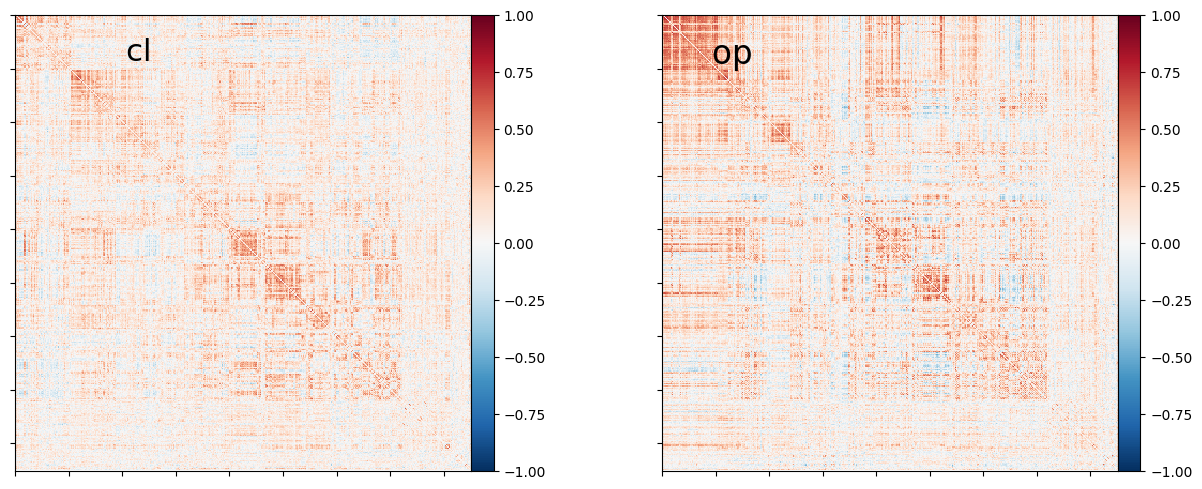

In [15]:
from nilearn import plotting

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

plotting.plot_matrix(
    reor_cl,
    labels=None,
    vmax=1,#np.max(fc6[0]),
    vmin=-1,#-np.max(fc6[0]),
    title="cl                              ",
    reorder=False, axes=ax1)

plotting.plot_matrix(
    reor_op,
    labels=None,
    vmax=1,#np.max(fc5[0]),
    vmin=-1,#-np.max(fc5[0]),
    title="op                                 ",
    reorder=False, axes=ax2)